In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
import yfinance as yf
import tensorflow as tf
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [105]:
#ignoring warnings
warnings.filterwarnings("ignore")

In [106]:
#setting start and end dates
end = pd.to_datetime('2024-11-04') 
start=datetime(end.year-10,end.month,end.day)

In [107]:
#getting stock data from yFinance
stock="GOOG"
df=yf.download(stock,start,end)

[*********************100%***********************]  1 of 1 completed


In [108]:
df.columns

MultiIndex([('Adj Close', 'GOOG'),
            (    'Close', 'GOOG'),
            (     'High', 'GOOG'),
            (      'Low', 'GOOG'),
            (     'Open', 'GOOG'),
            (   'Volume', 'GOOG')],
           names=['Price', 'Ticker'])

In [109]:
df.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,GOOG,GOOG,GOOG,GOOG,GOOG,GOOG
Date,,,,,,
2014-11-04 00:00:00+00:00,27.561954,27.629642,27.698954,27.389801,27.574295,24884132
2014-11-05 00:00:00+00:00,27.154577,27.221264,27.763775,27.128019,27.763775,40645286
2014-11-06 00:00:00+00:00,26.961582,27.027796,27.269382,26.974442,27.200321,26665008
2014-11-07 00:00:00+00:00,26.910349,26.976437,27.235723,26.859756,27.235723,32675465
2014-11-10 00:00:00+00:00,27.232672,27.299549,27.404263,26.976934,26.998875,22692131


In [110]:
#dropping multi-level index
df=df.droplevel(level=1,axis=1)
df.reset_index(inplace=True)

In [111]:
#extracting only date from Date column
df['Date']=df['Date'].dt.date
df['Date']=pd.to_datetime(df['Date'])
df.head()

Price,Date,Adj Close,Close,High,Low,Open,Volume
0,2014-11-04,27.561954,27.629642,27.698954,27.389801,27.574295,24884132
1,2014-11-05,27.154577,27.221264,27.763775,27.128019,27.763775,40645286
2,2014-11-06,26.961582,27.027796,27.269382,26.974442,27.200321,26665008
3,2014-11-07,26.910349,26.976437,27.235723,26.859756,27.235723,32675465
4,2014-11-10,27.232672,27.299549,27.404263,26.976934,26.998875,22692131


In [112]:
#checking shape of the dataframe
df.shape

(2516, 7)

In [113]:
#checking for null values
df.isnull().sum()

Price
Date         0
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64

In [114]:
#checking for duplicates
df.duplicated().sum()

np.int64(0)

In [115]:
#We are going to predict the 'Close' column
df=pd.DataFrame(df[['Date','Close']])
df.reset_index(drop=True)
df.columns.name=None
df.head()

,Date,Close
0,2014-11-04,27.629642
1,2014-11-05,27.221264
2,2014-11-06,27.027796
3,2014-11-07,26.976437
4,2014-11-10,27.299549


In [116]:
df.columns

Index(['Date', 'Close'], dtype='object')

In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2516 entries, 0 to 2515
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2516 non-null   datetime64[ns]
 1   Close   2516 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 39.4 KB


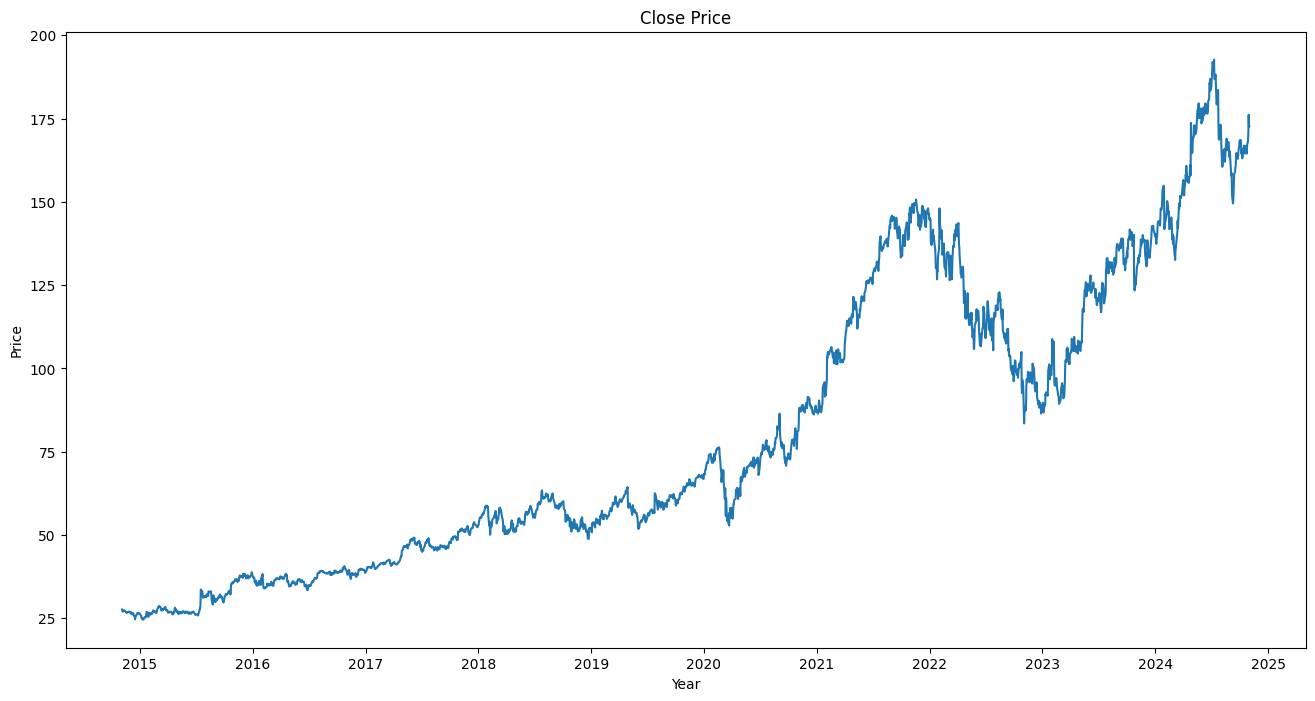

In [118]:
#ploting the data
plt.figure(figsize=(16,8))
sns.lineplot(data=df, x='Date', y='Close')
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Close Price')
plt.show()

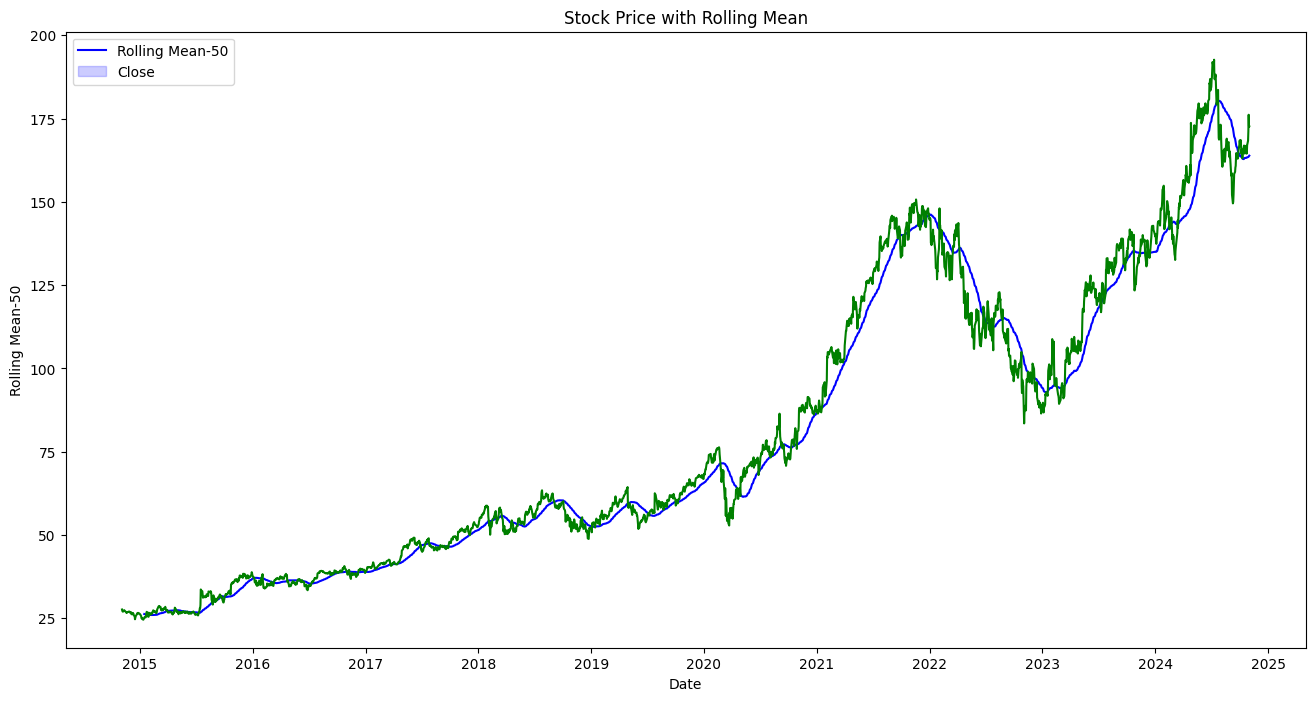

In [119]:
#using Moving Average (Rolling Mean) to observe trends(We continue with 50 day rolling mean)
 
#df['Rolling Mean-20']=df['Close'].rolling(window=20).mean()
df['Rolling Mean-50']=df['Close'].rolling(window=50).mean()
#df['Rolling Mean-200']=df['Close'].rolling(window=200).mean()
plt.figure(figsize=(16,8))
#sns.lineplot(data=df,x='Date',y='Rolling Mean-20',color='Red')
#sns.lineplot(data=df,x='Date',y='Rolling Mean-200',color='Purple')
sns.lineplot(data=df,x='Date',y='Rolling Mean-50',color='Blue')
sns.lineplot(data=df,x='Date',y='Close',color='Green')
plt.title('Stock Price with Rolling Mean')
plt.legend(['Rolling Mean-50','Close'],loc='upper left')
plt.show()

Here we apply Rolling Mean/Moving Average(50-Day) to smooth out short-term fluctations and highlight long-term trends.

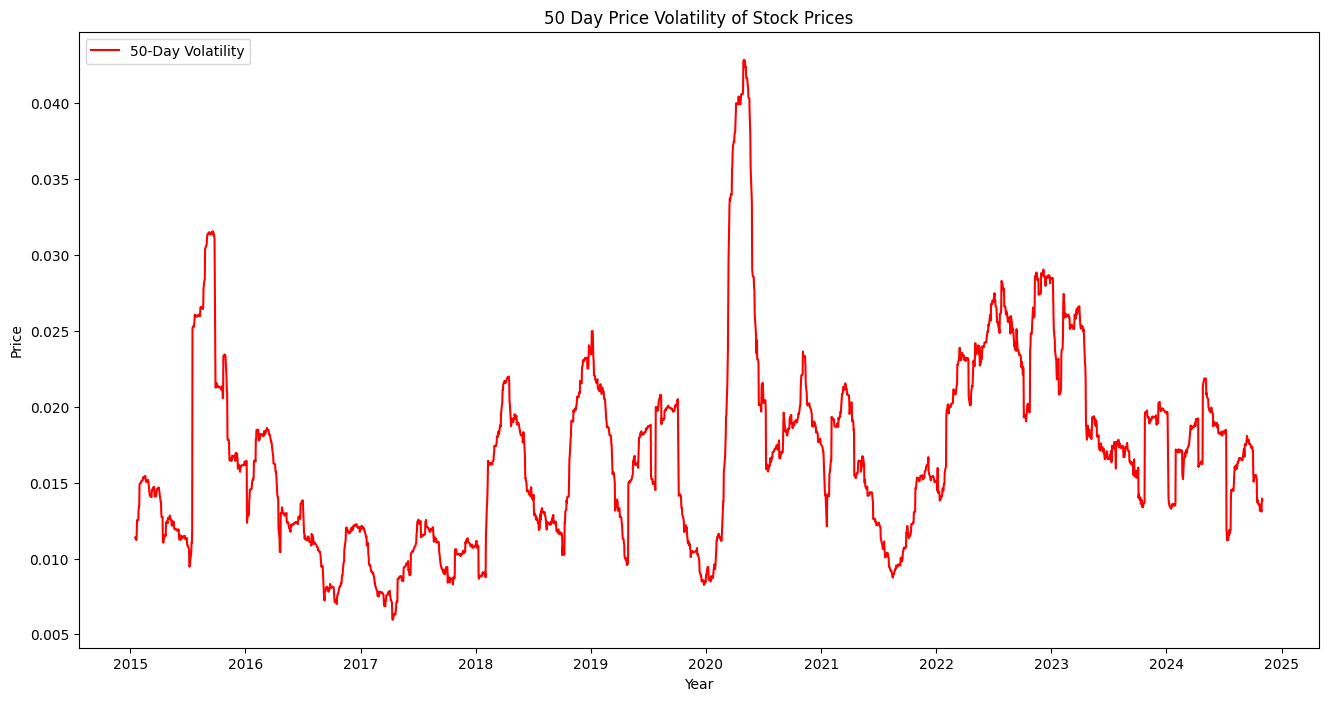

In [120]:
#calculating Volatility
df['Daily_Return']=df['Close'].pct_change() #Percentage change in closing price
df['Volatility_50']=df['Daily_Return'].rolling(window=50).std()

plt.figure(figsize=(16,8))
sns.lineplot(x='Date', y='Volatility_50', data=df, label='50-Day Volatility', color='red')
plt.title('50 Day Price Volatility of Stock Prices')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()

Volatility reflects how much the stock price fluctuates over a given period. High volatility means the stock price moves significantly (up or down) in a short time, while low volatility indicates more stable prices.

In [121]:
#using 'Augmented Dickey-Fuller Test' to check for stationarity
result=adfuller(df['Close'])
print("ADF Statisic:",result[0])
print('p-value',result[1])
if result[1]<0.05:
    print("The Time Series is Stationary")
else:
    print("The Time Series is Not Stationary")

ADF Statisic: 0.2549531857485095
p-value 0.9751807038429402
The Time Series is Not Stationary


The test results indicate that the time series of GOOG's closing prices over the past 10 years is not stationary.

Autocorrelation


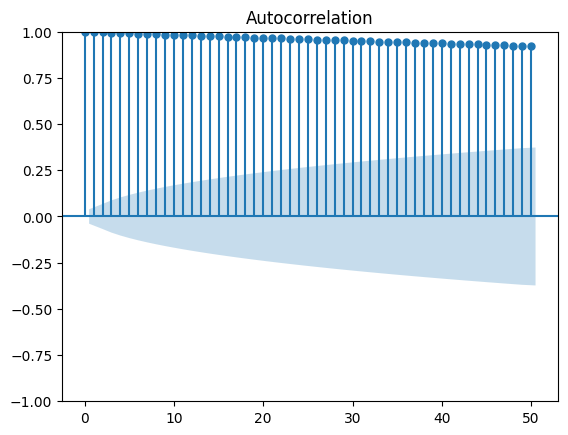

Partial Autocorrelation


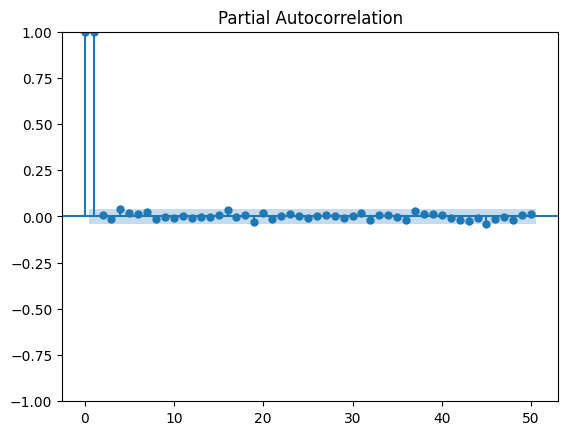

In [122]:
#checking 'autocorrelation' and 'partialcorrelation' to identify depedencies in the data
print("Autocorrelation")
plot_acf(df['Close'],lags=50)
plt.show()

print('Partial Autocorrelation')
plot_pacf(df['Close'],lags=50)
plt.show()

1. Autocorrelation plot
- Highly correlated.
    - The autocorrelation values are close to 1.0, which suggests high autocorrelation over many time steps. This indicates that the data points are strongly related to previous values, suggesting a high degree of persistence or trend in the dataset.
    - The shaded blue area represents the confidence interval. If any autocorrelation values fall outside this shaded area, they are statistically significant. Here, all values are well above the confidence interval, meaning the autocorrelations at these lags are statistically significant.

2. Partial Autocorrelation plot
- Strong partial autocorrelation in lag-1 and lag-2. But after lag-2 it indicates a cutoff. The bars fall within the confidence interval after lag-2, indicating that the partial autocorrelations at these lags are not statistically significant. Hence the partial autocorrelation suggests that an autoregressive model of order 2 (AR(2)) could be suitable for modeling the series. 

In [123]:
#creating lag features 
df.set_index('Date',inplace=True)
def create_lag_features(df,col,lags):
    for i in range(1,lags+1):
        df[f'{col}_lag-{i}']=df[col].shift(i)
    return df

In [124]:
df=create_lag_features(df,'Close',7)

In [125]:
#resetting index
df=df.reset_index()

In [126]:
#re-arranging DF

df=pd.DataFrame(df[['Date','Close','Rolling Mean-50','Daily_Return','Volatility_50','Close_lag-1','Close_lag-2','Close_lag-3','Close_lag-4','Close_lag-5','Close_lag-6','Close_lag-7']])
df.head()

,Date,Close,Rolling Mean-50,Daily_Return,Volatility_50,Close_lag-1,Close_lag-2,Close_lag-3,Close_lag-4,Close_lag-5,Close_lag-6,Close_lag-7
0,2014-11-04,27.629642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-11-05,27.221264,NaN,-0.014780,NaN,27.629642,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-11-06,27.027796,NaN,-0.007107,NaN,27.221264,27.629642,NaN,NaN,NaN,NaN,NaN
3,2014-11-07,26.976437,NaN,-0.001900,NaN,27.027796,27.221264,27.629642,NaN,NaN,NaN,NaN
4,2014-11-10,27.299549,NaN,0.011978,NaN,26.976437,27.027796,27.221264,27.629642,NaN,NaN,NaN


In [127]:
#checking for null values after setting lag features
tot=len(df['Close'])
nulls=df['Rolling Mean-50'].isnull().sum()
percentage=(nulls/tot)*100
print(round(percentage,2),'%','of values are null')

1.95 % of values are null


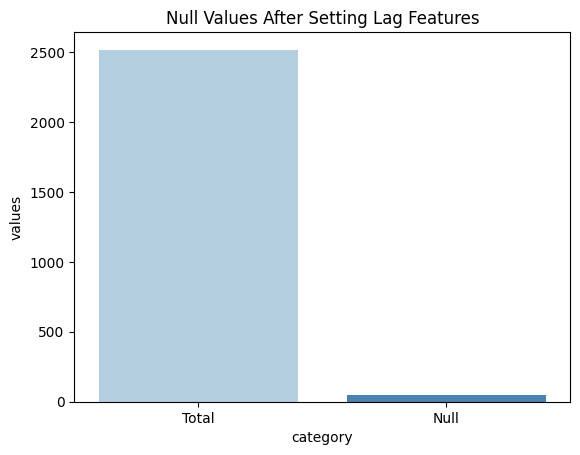

In [128]:
#plotting the null values after setting lag features
data={
    'category':['Total','Null'],
    'values':[tot,nulls]
}

sns.barplot(data=data, x='category', y='values', palette="Blues")
plt.title('Null Values After Setting Lag Features')
plt.show()

In [129]:
df.shape

(2516, 12)

In [130]:
#dropping rows with null values
df.dropna(inplace=True)
df.reset_index(inplace=True)
df.shape

(2466, 13)

In [131]:
#rearranging columns
df=pd.DataFrame(df[['Date','Rolling Mean-50','Volatility_50','Close_lag-1','Close_lag-2','Close_lag-3','Close_lag-4','Close_lag-5','Close_lag-6','Close_lag-7','Close']])

In [132]:
#sorting df by 'Date' to ensure that the data is in order
df=df.sort_values(by='Date')

In [133]:
#scaling columns
scaler=MinMaxScaler(feature_range=(-1,1))
cols_scale=['Rolling Mean-50','Volatility_50','Close_lag-1','Close_lag-2','Close_lag-3','Close_lag-4','Close_lag-5','Close_lag-6','Close_lag-7','Close']
df[cols_scale]=scaler.fit_transform(df[cols_scale])
df.head()

,Date,Rolling Mean-50,Volatility_50,Close_lag-1,Close_lag-2,Close_lag-3,Close_lag-4,Close_lag-5,Close_lag-6,Close_lag-7,Close
0,2015-01-16,-0.996653,-0.706668,-1.000000,-1.000000,-1.000000,-1.000000,-0.997852,-0.993990,-0.994928,-0.999297
1,2015-01-20,-0.997157,-0.715211,-0.996258,-0.999453,-0.997215,-0.997846,-1.000000,-0.997852,-0.993990,-1.000000
2,2015-01-21,-0.997467,-0.691138,-0.996960,-0.995712,-0.996668,-0.995064,-0.997846,-1.000000,-0.997852,-0.993363
3,2015-01-22,-0.997553,-0.644231,-0.990333,-0.996414,-0.992933,-0.994518,-0.995064,-0.997846,-1.000000,-0.983622
4,2015-01-23,-0.997650,-0.645813,-0.980607,-0.989789,-0.993633,-0.990787,-0.994518,-0.995064,-0.997846,-0.980309


In [134]:
#splitting dataset
X=df.iloc[:,0:10].values
y=df.iloc[:,10].values

In [135]:
#reshaping X,y into 3D 
def LSTM_dataset(X,y,time_steps=50):
    Xs,ys=[],[]
    for i in range(len(X)-time_steps):
        Xs.append(X[i:i+time_steps])
        ys.append(y[i+time_steps])
    return np.array(Xs),np.array(ys)

In [136]:
X_reshaped, y_reshaped = LSTM_dataset(X,y)

In [137]:
#splitting into train and test sets
X_train,X_test,y_train,y_test=train_test_split(X_reshaped,y_reshaped,test_size=0.2,shuffle=False)

#further spplitting train set into train and validation sets
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.2,shuffle=False)

In [138]:
# extracting 'Date' from X_train,X_test,X_val and dropping it

dates_train=X_train[:,0,0]
X_train=np.delete(X_train,0,axis=2)
X_train=X_train.astype('float32')

dates_test=X_test[:,0,0]
X_test=np.delete(X_test,0,axis=2)
X_test=X_test.astype('float32')

dates_val=X_val[:,0,0]
X_val=np.delete(X_val,0,axis=2)
X_val=X_val.astype('float32')

In [139]:
#chickint shape of splitted sets
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}')

X_train shape: (1545, 50, 9)
y_train shape: (1545,)
X_test shape: (484, 50, 9)
y_test shape: (484,)
X_val shape: (387, 50, 9)
y_val shape: (387,)


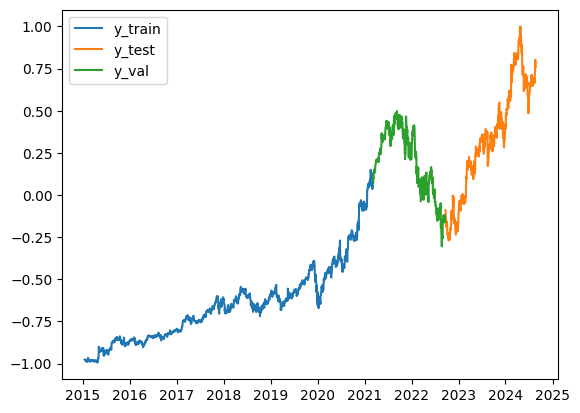

In [140]:
#plotting y_train,y_test,y_val
plt.plot(dates_train,y_train)
plt.plot(dates_test,y_test)
plt.plot(dates_val,y_val)
plt.legend(['y_train','y_test','y_val'])
plt.show()

In [141]:
#building model
model=Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],9)),    # first LSTM layer
    Dropout(0.4),   # dropout to prevent overfitting
    LSTM(units=50, return_sequences=False), # second LSTM layer
    Dropout(0.4),   
    Dense(units=1)  # output layer
])

#applyong learning rate scheduler - ReduceLROnPlateau
reduce_lr=ReduceLROnPlateau(
    monitor='val_loss', #monitor validation loss
    factor=0.1,         #reduce learning rate by a factor of 0.1
    patience=10,        #wait for 5 epochs with no improvement
    min_lr=1e-6         #minimum learning rate
)

# compile model
model.compile(
    optimizer='adam', 
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

In [142]:
# training model
history=model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=150, batch_size=128, callbacks=[reduce_lr])

Epoch 1/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - loss: 0.3069 - mean_absolute_error: 0.4485 - val_loss: 0.0115 - val_mean_absolute_error: 0.0940 - learning_rate: 0.0010
Epoch 2/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0362 - mean_absolute_error: 0.1511 - val_loss: 0.0079 - val_mean_absolute_error: 0.0779 - learning_rate: 0.0010
Epoch 3/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0266 - mean_absolute_error: 0.1332 - val_loss: 0.0061 - val_mean_absolute_error: 0.0681 - learning_rate: 0.0010
Epoch 4/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0226 - mean_absolute_error: 0.1186 - val_loss: 0.0050 - val_mean_absolute_error: 0.0604 - learning_rate: 0.0010
Epoch 5/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0206 - mean_absolute_error: 0.1125 - val_loss: 0.0046 - val_mean_absolute_error: 0.0571 - learning_rate: 0.0010
Epoch 6/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0181 - mean_absolute_error: 0.1041 - val_loss: 0.0046 - val_mean_ab

In [143]:
val_metrics = model.evaluate(X_val, y_val)
val_mse = val_metrics[0]  #the loss -> MSE 
val_mae = val_metrics[1]  #additional metric -> MAE

print(f"Validation MSE: {val_mse:.4f}")
print(f"Validation MAE: {val_mae:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0033 - mean_absolute_error: 0.0469
Validation MSE: 0.0046
Validation MAE: 0.0554


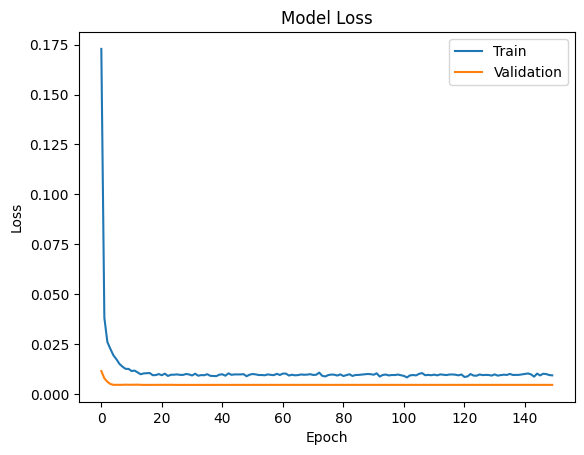

In [144]:
#ploting validation loss and train loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [145]:
y_pred=model.predict(X_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


In [146]:
# Calculating MSE on the test set
test_mse = mean_squared_error(y_test, y_pred)
print(f"Test Mean Squared Error (MSE): {test_mse:.4f}")

Test Mean Squared Error (MSE): 0.0119


In [147]:
#reverting scaler transformation
#to apply scaler.inverse_transform() we need the same exact shape of the array, we used for scaling.
#we follow the steps below to conver y_train,y_test,y_val and y_pred to convert it into the shape when it was scaling.

#converting into 2D array
y_train=np.array(y_train).reshape(-1,1)
y_val=np.array(y_val).reshape(-1,1)
y_test=np.array(y_test).reshape(-1,1)
y_pred=np.array(y_pred).reshape(-1,1)

#creating a temporary array to match the shape used for scaling
#we use the same number of features as in the original data
temp_train=np.zeros((y_train.shape[0],10))
temp_val=np.zeros((y_val.shape[0],10))
temp_test=np.zeros((y_test.shape[0],10))
temp_pred=np.zeros((y_pred.shape[0],10))

#filling first column with values we want to revert
temp_train[:,0]=y_train[:,0]
temp_val[:,0]=y_val[:,0]
temp_test[:,0]=y_test[:,0]
temp_pred[:,0]=y_pred[:,0]

#applying inverse scaling
y_train_original=scaler.inverse_transform(temp_train)
y_val_original=scaler.inverse_transform(temp_val)
y_test_original=scaler.inverse_transform(temp_test)
y_pred_original=scaler.inverse_transform(temp_pred)

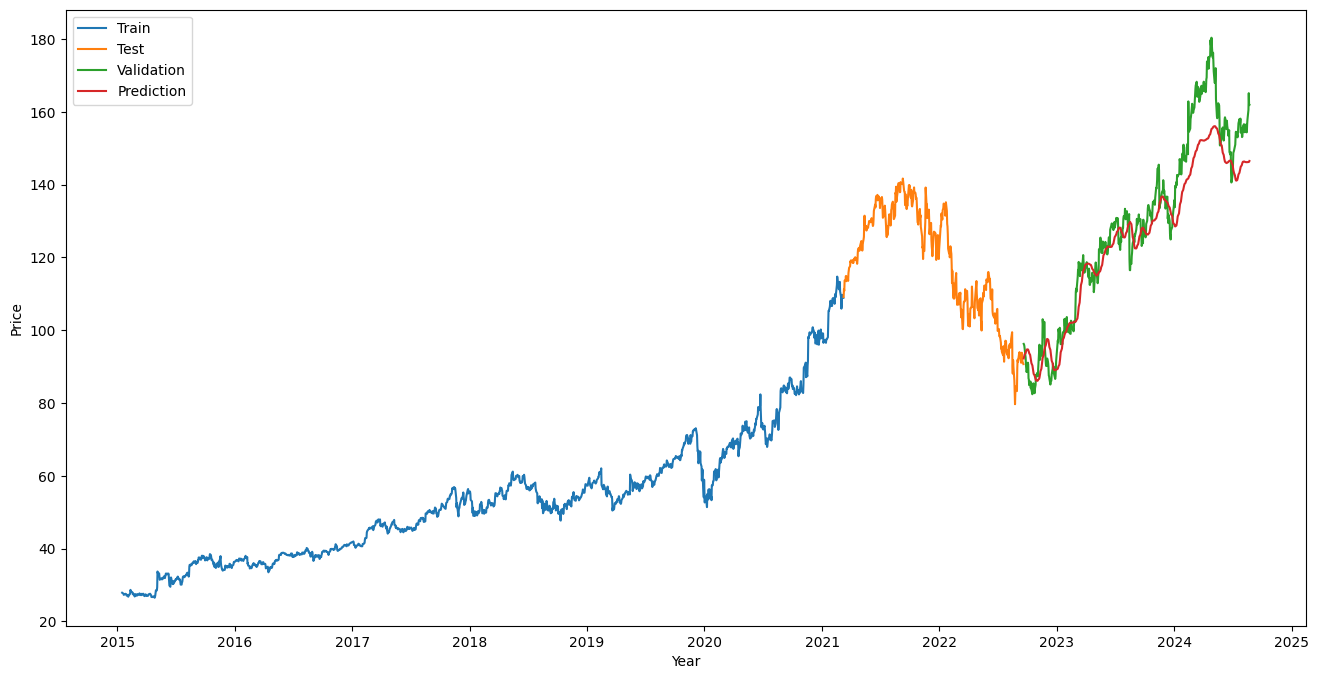

In [148]:
#plotting predictions againt test
plt.figure(figsize=(16,8))
plt.plot(dates_train,y_train_original[:,0])
plt.plot(dates_val,y_val_original[:,0])
plt.plot(dates_test,y_test_original[:,0])
plt.plot(dates_test,y_pred_original[:,0])
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend(['Train','Test','Validation','Prediction'])
plt.show()

In [149]:
#saving model
model.save('stock_price_predictor.h5')